# IMDB Movie Review Classification Project (NLP)

## Team members
helliem, Matthew Hellie, 79154496

## Introduction (2 pts)



This project will try to automatically classify movie reviews as positive or negative based on the sentiment expressed. Simply labeling a review as positive or negative, rather than using the 5-star system or reading a long review, could be helpful for both movie producers and consumers by making it easier to make a recommendation system. It could also provide new insight into the movies reception because sometimes people rate using the 5 star system with no review, the written reviews don't always match their star rating, and the people who leave written reviews generally have more specific feedback and critiques. And in general, this project demonstrates the the process of Natural Language Processing and the effectiveness/usefulness of neural networks.

## Dataset Description (5 pts)


The IMDB movie review dataset contains 50,000 total reviews. There are 2 columns, one for the review, and one for its matching sentiment. The sentiment only has 2 unique values, making it easy for a binary classification task.

Dataset Origin: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews/data

1) Publically available

2) Dataset ownership: Maas, Andrew L., et al. "Learning Word Vectors for Sentiment Analysis." Proceedings of the 49th Annual Meeting of the Association for Computational Linguistics: Human Language Technologies. Association for Computational Linguistics, June 2011, pp. 142-150





### Code Section for Loading the Dataset (3 pts)

In [1]:
import pandas as pd
from google.colab import drive
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer

# mount Google Drive and load dataset
drive.mount('/content/drive', force_remount=True)
dataSet = '/content/drive/MyDrive/Deep_Learning/Project/IMDB_Dataset.csv'
df = pd.read_csv(dataSet)

# download libraries to help process review text
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):

    text = text.lower()
    # remove HTML tags and special characters
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    # tokenize the review text and remove stop words
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stop_words]
    # join tokens back together
    preprocessed_text = ' '.join(filtered_tokens)
    return preprocessed_text

# clean reviews by removing unnesscary words and characters
cleaned_reviews = df['review'].apply(clean_text).tolist()

# tokenize the reviews
tokenizer = Tokenizer()
tokenizer.fit_on_texts(cleaned_reviews)
tokenized_reviews = tokenizer.texts_to_sequences(cleaned_reviews)
vocab_size = len(tokenizer.word_index) + 1




Mounted at /content/drive


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Model Description (15 pts)



For this project, I've chosen a Convolutional Neural Network (CNN). I chose this model because CNNs are well-suited for sequential data due to their ability to capture spatial and temporal patterns. In this architecture, I've integrated multiple layers, including an embedding layer, a 1D convolutional layer followed by max-pooling, dropout for regularization, and a dense layer with a sigmoid activation function for binary classification.

Regarding the model's complexity, due the large vocabulary size, sequence length, and embedding dimension, the amount of parameters ends up being around 5 million (as shown in the model summary). After experiementing with many values, I found that 200 and 50 for the sequence and embedding dimension to be the sweet spot.

### Code Section for Loading Project Model (10 pts)

In [2]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Conv1D, Dropout, Dense, MaxPooling1D, Flatten

# pad sequences
maxlen = 200
padded_reviews = pad_sequences(tokenized_reviews, maxlen)

# convert sentiment labels to 0(negative) or 1(positive)
labels = np.array(df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0))

# split the dataset, 20% for testing(10,000), 80% for training(40,000).
X_train, X_test, y_train, y_test = train_test_split(padded_reviews, labels, test_size=0.2, random_state=33)

# define model parameters
embedding_dim = 50

# load the Convolutional Neural Network model
CNN = Sequential()
CNN.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
CNN.add(Conv1D(filters=32, kernel_size=5, activation='relu'))
CNN.add(MaxPooling1D(pool_size=4))
CNN.add(Dropout(0.5))
CNN.add(Flatten())
CNN.add(Dense(1, activation='sigmoid'))

# compile the model and set learning rate
my_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
CNN.compile(optimizer = my_optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

# show the model summary
print(CNN.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 50)           5062050   
                                                                 
 conv1d (Conv1D)             (None, 196, 32)           8032      
                                                                 
 max_pooling1d (MaxPooling1  (None, 49, 32)            0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 49, 32)            0         
                                                                 
 flatten (Flatten)           (None, 1568)              0         
                                                                 
 dense (Dense)               (None, 1)                 1569      
                                                        

## Model Training and Validation Description and Experiments (55 pts)

The optimization algorithm chosen for the training process was Adam. This choice was made due to its adaptive learning rate and momentum capabilities, which enable faster convergence and improved performance. I've experiemtned with others like RMSprop, but Adam gave the best results by far. I gave it an intial learning rate of 0.0001 because larger inital rates seemed to cause significant overfitting after just a few epochs. The batch size for training was set to 128, as this seemed to give good results in terms of speed and accuracy/loss. I've set the training to conclude after 10 epochs because it seemed to improve exponentially less after this point and start overfitting.

For the loss function, I have been stuck trying to decide between 'binary corss-entropy' and 'mse'. Binary cross-entropy is better suited for binary classificaiton, but I am also able to significatnly reduce the validation loss by using mse. However, I wasn't sure if the lower loss value was misleading or not since nothing else changed, so I decided to just stick with binary-crossentropy since it makes more since for this type of problem.

For the dataset division, the dataset of 50,000 IMDb reviews was split using 80% as the training data, and 20% as the validation data. I made the training set much larger so that it would have more vocabulary variety to train on. The data was shuffled using random_state=33 before splitting to prevent any bias in the original ordering.

Metrics used to evaluate model performance:

-Accuracy: Measures the ratio of correctly predicted instances to the total number of instances.

-Loss: Measures the discrepancy between the true values and the predicted values generated by the model.

-Precision: Quantifies the number of true positive predictions divided by the total number of positive predictions made by the model (false positives).

-Recall: Calculates the ratio of true positive predictions to the total number of actual positive instances (false negatives).

-F1 Score: Mean of precision and recall. Gives insights into the model's performance across different classes.

 Since the goal of this project is just to determine weather a review is positive or negative as accuratly as possible, these metrics are a great way to measure the models accuracy and effectiveness.

 After experimenting with many different parameters and making adjustments, 90% accuracy was the best I was able to achieve. At first I wasn't happy with this number as I wanted above 95%, but then I realized that this is actually pretty good considering the subjectiveness and complexity that some reviews may have. I thought leaving it at 90% was ok since trying to improve it from there would be pretty difficult without knowing exactly what its lacking.


### Code Section for Performing Training (if applicable) and Evaluation and Plot Generations (25 pts)

Epoch 1/10
313/313 [==============================] - 51s 145ms/step - loss: 0.6928 - accuracy: 0.5095 - val_loss: 0.6916 - val_accuracy: 0.5432
Epoch 2/10
313/313 [==============================] - 29s 91ms/step - loss: 0.6860 - accuracy: 0.5899 - val_loss: 0.6831 - val_accuracy: 0.6709
Epoch 3/10
313/313 [==============================] - 21s 68ms/step - loss: 0.6469 - accuracy: 0.7491 - val_loss: 0.5824 - val_accuracy: 0.8259
Epoch 4/10
313/313 [==============================] - 17s 55ms/step - loss: 0.4444 - accuracy: 0.8575 - val_loss: 0.3478 - val_accuracy: 0.8730
Epoch 5/10
313/313 [==============================] - 11s 36ms/step - loss: 0.2859 - accuracy: 0.8951 - val_loss: 0.2793 - val_accuracy: 0.8899
Epoch 6/10
313/313 [==============================] - 10s 31ms/step - loss: 0.2237 - accuracy: 0.9193 - val_loss: 0.2546 - val_accuracy: 0.8985
Epoch 7/10
313/313 [==============================] - 9s 28ms/step - loss: 0.1875 - accuracy: 0.9334 - val_loss: 0.2461 - val_accuracy:

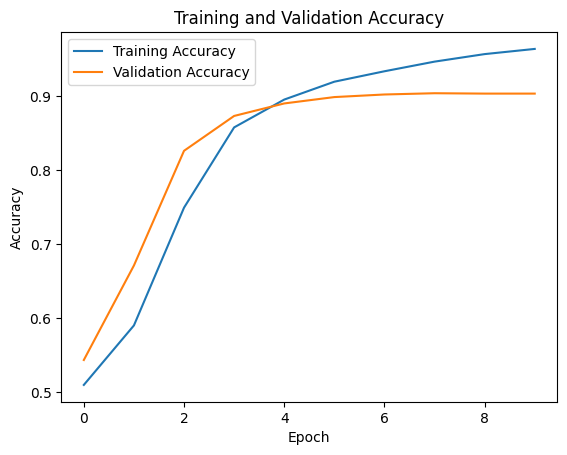

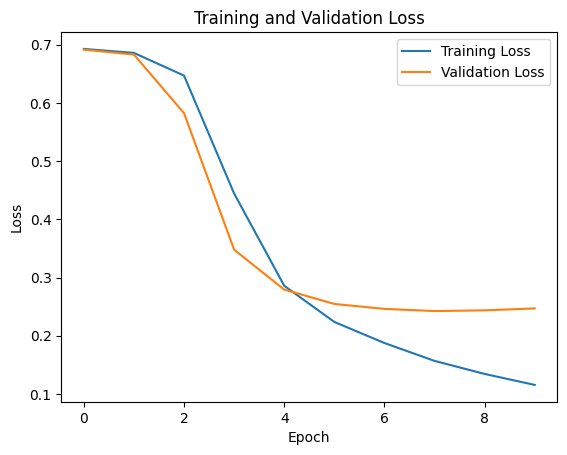

In [3]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# train the model
training = CNN.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test))

# evaluate the model
loss, accuracy = CNN.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# get predictions
y_pred = CNN.predict(X_test)
y_pred_binary = [1 if pred > 0.5 else 0 for pred in y_pred]

# calculate precision, recall, and F1 score
report = classification_report(y_test, y_pred_binary)
print("Classification Report:")
print(report)

# compare training and evaluation accuracy
plt.plot(training.history['accuracy'], label='Training Accuracy')
plt.plot(training.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# compare training and evaluation loss
plt.plot(training.history['loss'], label='Training Loss')
plt.plot(training.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


## Conclusion (3 pts)


The primary objective of this project was to train the model in order to predict and classify an IMDb review as 'positive' or 'negative', and seeing how I was able to get an accuracy of 90%, I think this goal was met.

Working on this project has given me a much better understanding of Deep Learning and NLP. Experimenting with different model architectures, algorithms, and parameters, has given me a much better understanding of how different components in a model interact with each other. I noticed that even the smallest changes can significantly improve or worsen results. The whole process of making a convolution neural network has helped me enhance my technical skills and my knowledge of deep learning and its real-world applications.

## Contributions (15 pts)







*Undergrad student*